In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

/opt/anaconda3/envs/yt/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [3]:
from scipy.interpolate import splev, splrep, interp1d, splint

In [4]:
raw_190, raw114_190, raw_190_peri, raw114_190_peri = np.load(
    'data/m1.0_p10_b1.0_90.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_90.npz'), np.load(
            'data/m1.0_p10_b1.0_peri_90.npz'), np.load(
                'data/m1.0_p10_b1.0_P110_peri_90.npz')

In [5]:
def linear_regression(x, y):
    X = np.array([[(x**2).sum(), (x).sum()],
              [(x).sum(), len(x)]])
    Y = np.array([[(x * y).sum()], [(y).sum()]])
    A, B = np.matmul(np.linalg.inv(X), Y)
    return A, B

In [6]:
def combine(raw, raw_peri):
    x_peri, E_peri = raw_peri['x'], raw_peri['y']
    xmin = np.argmin(x_peri)
    x_peri, E_peri = x_peri[xmin:], E_peri[xmin:]
    x, E = raw['x'], raw['y']
    xmin = np.argmin(x)
    x, E = x[xmin:], E[xmin:]
    E = E[x > x_peri[-1]]
    x = x[x > x_peri[-1]]
    dat = {}
    dat['x'] = np.append(x_peri, x)
    dat['y'] = np.append(E_peri, E)
    return dat

In [7]:
def bin_after(raw, dis, bins=10):
    x = (raw['x'] * u.cm).in_units('Rsun')
    y = np.log10(raw['y'])
    l = len(x[x > dis])
    size = l // bins
    xafter = np.array(
        [x[x > dis][i * size:i * size + bins].mean() for i in range(bins)])
    yafter = np.array(
        [y[x > dis][i * size:i * size + bins].mean() for i in range(bins)])
    xout = np.append(x[x < dis], xafter) * u.Rsun / u.cm
    return {'x': xout.in_cgs(), 'y': 10**np.append(y[x < dis], yafter)}

In [8]:
def smooth_evol(raw, ax, label, lens=65, lower=-1, s=1e-4, rp=1, color=None):
    x = (raw['x'][lower:] * u.cm).in_units('Rsun').v
    y = np.log10(raw['y'][lower:])
    spl = splrep(x, y, s=s, k=5)
    x1 = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)
    y1 = 10**splev(x1, spl)
    ax.plot(x1 / rp, y1, label=label, color=color, linewidth=3)
    return spl, x[0], x[-1]


def smooth_evol_bin(raw, lower=4, bins=5):
    x = np.log10((raw['x'][lower:] * u.cm).in_units('Rsun').v)
    y = np.log10(raw['y'][lower:])
    X = np.array([x[i:i + bins].mean() for i in range(len(x) - bins)])
    Y = np.array([y[i:i + bins].mean() for i in range(len(x) - bins)])
    return 10**X, 10**Y

In [9]:
def plot_ed(raw, raw114, rawe, bins=10):
    r = np.array([3, 4])

    f, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

    ax[0].plot((raw['x'][4:] * u.cm).in_units('Rsun'), raw['y'][4:])
    s = smooth_evol_bin(raw, bins=bins)
    ax[1].plot(s[0], s[1], color='k')

    ax[0].plot((raw114['x'][4:] * u.cm).in_units('Rsun'), raw114['y'][4:])
    s_114 = smooth_evol_bin(raw114, bins=bins)
    ax[1].plot(s_114[0], s_114[1], color='grey')

    ax[0].plot((rawe['x'][8:] * u.cm).in_units('Rsun'), rawe['y'][8:])
    s_e = smooth_evol_bin(rawe, bins=bins, lower=8)
    ax[1].plot(s_e[0], s_e[1], color='grey', linestyle='--')

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    #ax[0].set_xlim(1e3, 4e3)
    f.tight_layout()
    plt.show()

## Cut by Tails

In [9]:
tail_1, tail_0_8, tail_0_5 = np.load(
    'data/m1.0_p10_b1.0_tail.npz'), np.load(
        'data/m1.0_p10_b0.8_tail.npz'), np.load(
            'data/m1.0_p10_b0.5_tail.npz')
tail_0_5_e9 = np.load('data/m1.0_p10_b0.5_e9_tail.npz')

Text(0, 0.5, '$\\Delta \\epsilon/\\delta_E$')

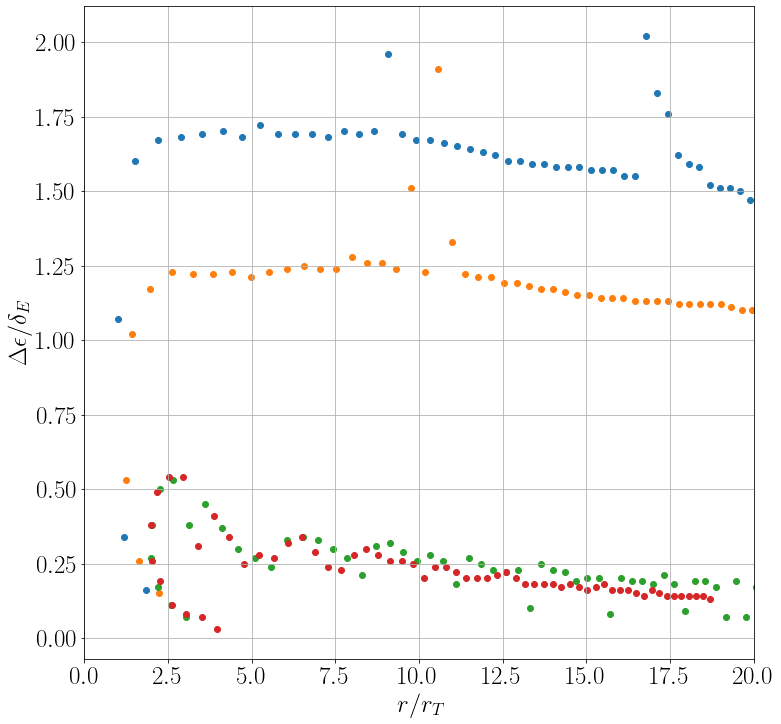

In [14]:
plt.figure(figsize=(12, 12))
plt.scatter(tail_1['x']/tail_1['x'].min(), tail_1['y'], label=r'$\beta=1$')
plt.scatter(tail_0_8['x']/tail_0_8['x'].min()*(1/0.8), tail_0_8['y'], label=r'$\beta=0.8$')
plt.scatter(tail_0_5['x']/tail_0_5['x'].min()*(1/0.5), tail_0_5['y'], label=r'$\beta=0.5$')
plt.scatter(tail_0_5_e9['x']/tail_0_5_e9['x'].min()*(1/0.5), tail_0_5_e9['y'], label=r'$\beta=0.5,\ e=0.9$')
plt.xlim(0, 20)
#plt.ylim(0, 0.6)
plt.grid()
plt.xlabel(r'$r/r_T$')
plt.ylabel(r'$\Delta \epsilon/\delta_E$')

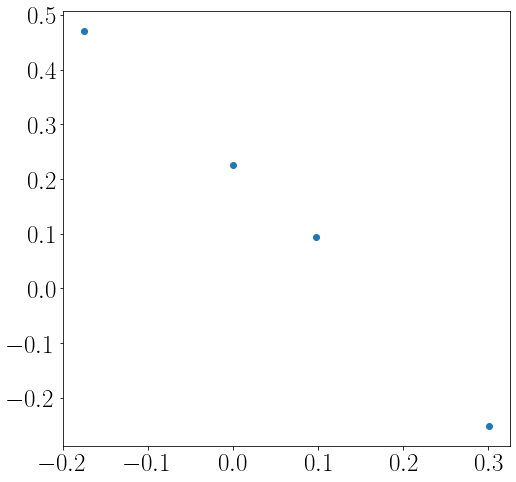

In [18]:
beta = np.array([0.5, 0.8, 1.0, 1.5])
dE = np.array([0.56, 1.24, 1.68, 2.96])
plt.figure(figsize=(8, 8))
plt.scatter(np.log10(1/beta), np.log10(dE))
plt.xticks([-0.2,-0.1,0,0.1,0.2,0.3])
plt.show()

## Cut by Unbound Mass

In [10]:
ubd_190, ubd114_190, ubde_190 = np.load(
    'data/m1.0_p10_b1.0_90_ubd.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_90_ubd.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_90_ubd.npz')
ubd_150, ubd114_150, ubde_150 = np.load(
    'data/m1.0_p10_b1.0_50_ubd.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_50_ubd.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_50_ubd.npz')

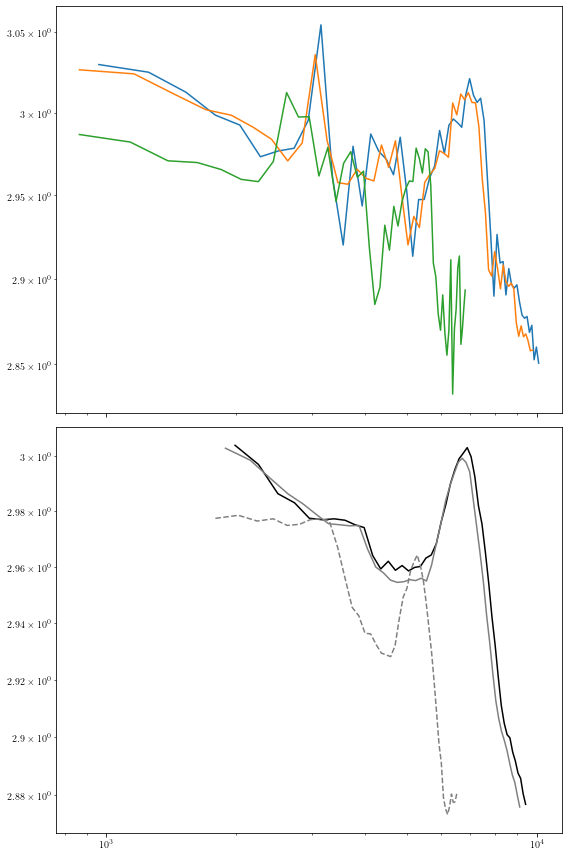

In [11]:
plot_ed(ubd_190, ubd114_190, ubde_190)

## Cut by Energy

In [10]:
de_198, de114_198, dee_198 = np.load(
    'data/m1.0_p10_b1.0_98_de.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_98_de.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_98_de.npz')
de_0899, de114_0899, dee_0899 = np.load(
    'data/m1.0_p10_b0.8_99_de.npz'), np.load(
        'data/m1.0_p10_b0.8_P110_99_de.npz'), np.load(
            'data/m1.0_p10_b0.8_e9_99_de.npz')
de_277, de114_277, dee_277 = np.load(
    'data/m1.0_p10_b2.0_77_de.npz'), np.load(
        'data/m1.0_p10_b2.0_P110_77_de.npz'), np.load(
            'data/m1.0_p10_b2.0_e9_77_de.npz')

In [11]:
de_198_peri, de114_198_peri, dee_198_peri = np.load(
    'data/m1.0_p10_b1.0_peri_98_de.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_peri_98_de.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_peri_98_de.npz')

de_0899_peri, de114_0899_peri, dee_0899_peri = np.load(
    'data/m1.0_p10_b0.8_peri_99_de.npz'), np.load(
        'data/m1.0_p10_b0.8_P110_peri_99_de.npz'), np.load(
            'data/m1.0_p10_b0.8_e9_peri_99_de.npz')

de_277_peri, de114_277_peri, dee_277_peri = np.load(
    'data/m1.0_p10_b2.0_peri_77_de.npz'), np.load(
        'data/m1.0_p10_b2.0_P110_peri_77_de.npz'), np.load(
            'data/m1.0_p10_b2.0_e9_peri_77_de.npz')

In [12]:
de_198 = combine(de_198, de_198_peri)
de114_198 = combine(de114_198, de114_198_peri)
dee_198 = combine(dee_198, dee_198_peri)

de_0899 = combine(de_0899, de_0899_peri)
de114_0899 = combine(de114_0899, de114_0899_peri)
dee_0899 = combine(dee_0899, dee_0899_peri)

de_277 = combine(de_277, de_277_peri)
de114_277 = combine(de114_277, de114_277_peri)
dee_277 = combine(dee_277, dee_277_peri)

In [13]:
def plot_de(raw,
            raw114,
            rawe,
            rp1,
            beta=1,
            lower=[0, 0, 0],
            rpmin=2.5,
            rpmax=8):

    rT = rp1 * beta

    f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    bin114 = bin_after(raw114, dis=5 * rT, bins=10)
    ax[0].scatter((raw114['x'] / rT).in_cgs(), raw114['y'])
    spl2, xmin1, xmax1 = smooth_evol(bin114,
                                     ax[0],
                                     '$P = 114\ \mathrm{d}$',
                                     lens=60,
                                     lower=lower[1],
                                     s=1e-4,
                                     rp=rT)

    bine = bin_after(rawe, dis=5 * rT, bins=10)
    ax[0].scatter((rawe['x'] / rT).in_cgs(), rawe['y'])
    spl3, xmin2, xmax2 = smooth_evol(bine,
                                     ax[0],
                                     '$e = 0.9$',
                                     lens=60,
                                     lower=lower[2],
                                     s=2e-5,
                                     rp=rT)

    bin = bin_after(raw, dis=5 * rT, bins=10)
    ax[0].scatter((raw['x'] / rT).in_cgs(), raw['y'])
    spl1, xmin, xmax = smooth_evol(bin,
                                   ax[0],
                                   '$\mathrm{Parabolic}$',
                                   lens=60,
                                   lower=lower[0],
                                   s=1e-4,
                                   rp=rT)

    r = np.array([rp1, rpmin * rT])
    ax[1].plot(r / rT, [0, 1 - 10**(splev(r[1], spl1) - splev(r[1], spl2))],
               linestyle='--')
    ax[1].plot(r / rT, [0, 1 - 10**(splev(r[1], spl1) - splev(r[1], spl3))],
               linestyle='--')

    r1 = np.logspace(np.log10(rpmin * rT), np.log10(rpmax * rT), 50)
    ax[1].scatter(r1 / rT, 1 - 10**(splev(r1, spl1) - splev(r1, spl2)))
    r2 = np.logspace(np.log10(rpmin * rT), np.log10(rpmax * rT), 50)
    ax[1].scatter(r2 / rT, 1 - 10**(splev(r2, spl1) - splev(r2, spl3)))

    ax[0].set_xlim(0, rpmax)
    #ax[0].set_ylim(1.95, 2.05)
    #ax[0].set_xscale('log')
    #ax[1].set_ylim(0, 0.01)
    #ax[1].set_yscale('log')

    ax[0].set_xlabel(r'$r/r_\mathrm{T}$', fontsize=25)
    ax[0].set_ylabel(r'$\Delta E/\delta E$', fontsize=25)
    ax[1].set_xlabel(r'$r/r_\mathrm{T}$', fontsize=25)
    ax[1].set_ylabel(r'$\mathrm{Deviation}$', fontsize=25)
    ax[0].tick_params(labelsize=20)
    ax[1].tick_params(labelsize=20)
    ax[0].legend(prop={'size': 20})
    f.tight_layout()
    return f

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


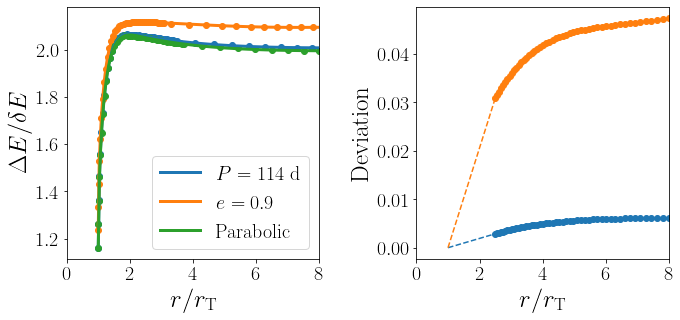

In [14]:
f = plot_de(de_198,
            de114_198,
            dee_198,
            rp1=(de_198_peri['x'] * u.cm).in_units('Rsun').min())
#f.savefig('DeltaE_radius.pdf', b)
#plot_de(de_190, de114_190, dee_190, rp1=rp1)

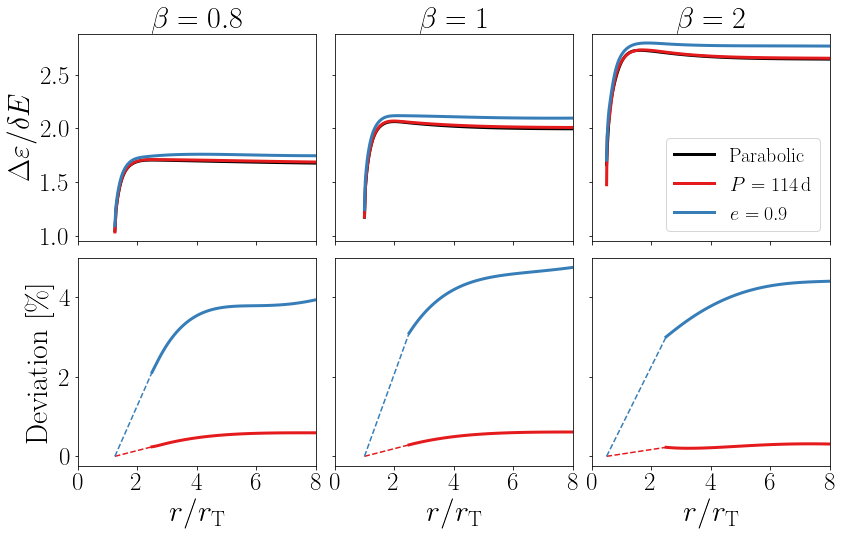

In [31]:
col = ['k', '#e41a1c', '#377eb8', '#4daf4a']
DE = [de_0899, de_198, de_277]
DEperi = [de_0899_peri, de_198_peri, de_277_peri]
DE114 = [de114_0899, de114_198, de114_277]
DEe = [dee_0899, dee_198, dee_277]
RP = [(peri['x'] * u.cm).in_units('Rsun').min() for peri in DEperi]
BETA = [0.8, 1, 2]
lower = [0, 0, 0]
rpmin = 2.5
rpmax = 8

f, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey='row', )
ax = ax.flatten()

titles = [r'$\beta=0.8$', r'$\beta=1$', r'$\beta=2$']

for k in range(3):
    raw, raw114, rawe, rp1, beta = DE[k], DE114[k], DEe[k], RP[k], BETA[k]
    rT = rp1 * beta

    bin = bin_after(raw, dis=5 * rT, bins=10)
    #ax[k].scatter((raw['x'] / rT).in_cgs(), raw['y'], color=col[1])
    spl1, xmin, xmax = smooth_evol(bin,
                                   ax[k],
                                   '$\mathrm{Parabolic}$',
                                   lens=60,
                                   lower=lower[0],
                                   s=1e-4,
                                   rp=rT,
                                   color=col[0])
    
    bin114 = bin_after(raw114, dis=5 * rT, bins=10)
    #ax[k].scatter((raw114['x'] / rT).in_cgs(), raw114['y'], color=col[0])
    spl2, xmin1, xmax1 = smooth_evol(bin114,
                                     ax[k],
                                     '$P = 114\,\mathrm{d}$',
                                     lens=60,
                                     lower=lower[1],
                                     s=1e-4,
                                     rp=rT,
                                     color=col[1])

    bine = bin_after(rawe, dis=5 * rT, bins=10)
    #ax[k].scatter((rawe['x'] / rT).in_cgs(), rawe['y'], color=col[2])
    spl3, xmin2, xmax2 = smooth_evol(bine,
                                     ax[k],
                                     '$e = 0.9$',
                                     lens=60,
                                     lower=lower[2],
                                     s=2e-5,
                                     rp=rT,
                                     color=col[2])


    r = np.array([rp1, rpmin * rT])
    ax[k + 3].plot(
        r / rT, [0, (1 - 10**(splev(r[1], spl1) - splev(r[1], spl2))) * 100],
        linestyle='--',
        color=col[1])
    ax[k + 3].plot(
        r / rT, [0, (1 - 10**(splev(r[1], spl1) - splev(r[1], spl3))) * 100],
        linestyle='--',
        color=col[2])

    r1 = np.logspace(np.log10(rpmin * rT), np.log10(rpmax * rT), 50)
    ax[k + 3].plot(r1 / rT,
                   (1 - 10**(splev(r1, spl1) - splev(r1, spl2))) * 100,
                   color=col[1],
                   linewidth=3)
    r2 = np.logspace(np.log10(rpmin * rT), np.log10(rpmax * rT), 50)
    ax[k + 3].plot(r2 / rT,
                   (1 - 10**(splev(r2, spl1) - splev(r2, spl3))) * 100,
                   color=col[2],
                   linewidth=3)

    ax[k].set_xlim(0, rpmax)
    ax[k].set_xticks([0, 2, 4, 6, 8])
    ax[k].set_title(titles[k], fontsize=30)
    ax[k].tick_params(labelsize=25)
    ax[k + 3].tick_params(labelsize=25)

    ax[k + 3].set_xlabel(r'$r/r_\mathrm{T}$', fontsize=30)

ax[2].legend(prop={'size':20})
ax[0].set_ylabel(r'$\Delta \varepsilon/\delta E$', fontsize=30)
ax[3].set_ylabel(r'$\mathrm{Deviation}\ [\%]$', fontsize=30)
f.tight_layout()
f.subplots_adjust(wspace=0.08, hspace=0.08)

plt.savefig('dEde.pdf', bbox_inches='tight')

## Cut By Total Mass

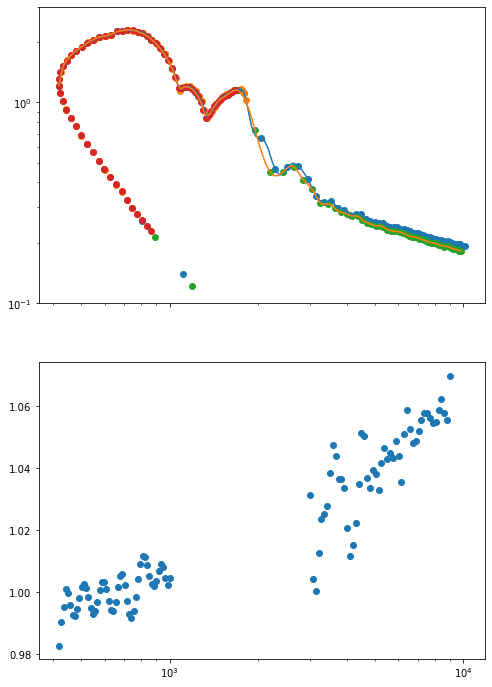

(1.0, 1.1)

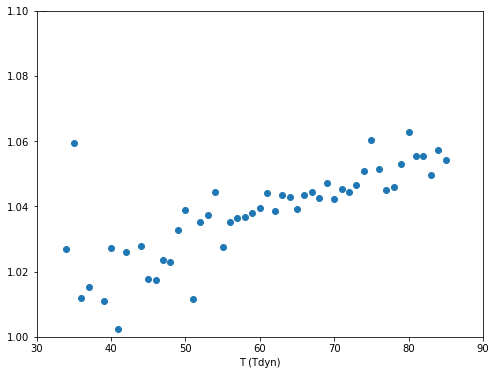

In [174]:
f, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
ax[0].scatter((raw_190['x'] * u.cm).in_units('Rsun'), raw_190['y'])
ax[0].scatter((raw_190_peri['x'] * u.cm).in_units('Rsun'), raw_190_peri['y'])
spl1, xmin = smooth_evol(combine(raw_190, raw_190_peri),
                         ax[0],
                         'None',
                         lens=60)
ax[0].scatter((raw114_190['x'] * u.cm).in_units('Rsun'), raw114_190['y'])
ax[0].scatter((raw114_190_peri['x'] * u.cm).in_units('Rsun'),
              raw114_190_peri['y'])
spl2, xmin = smooth_evol(combine(raw114_190, raw114_190_peri),
                         ax[0],
                         'None',
                         lens=60)
#plt.xlim(300, 1e4)
r = np.append(np.logspace(np.log10(xmin), 3, 50),
              np.logspace(np.log10(3000), np.log10(9000), 50))
ax[1].scatter(r, 10**(splev(r, spl1) - splev(r, spl2)))
ax[0].set_ylim(1e-1, 3)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(
    np.arange(len(raw_190['x'])) + 20, (raw_190['y'] / raw114_190['y']))
plt.xlabel('T (Tdyn)')
plt.xlim(30, 90)
plt.ylim(1, 1.1)

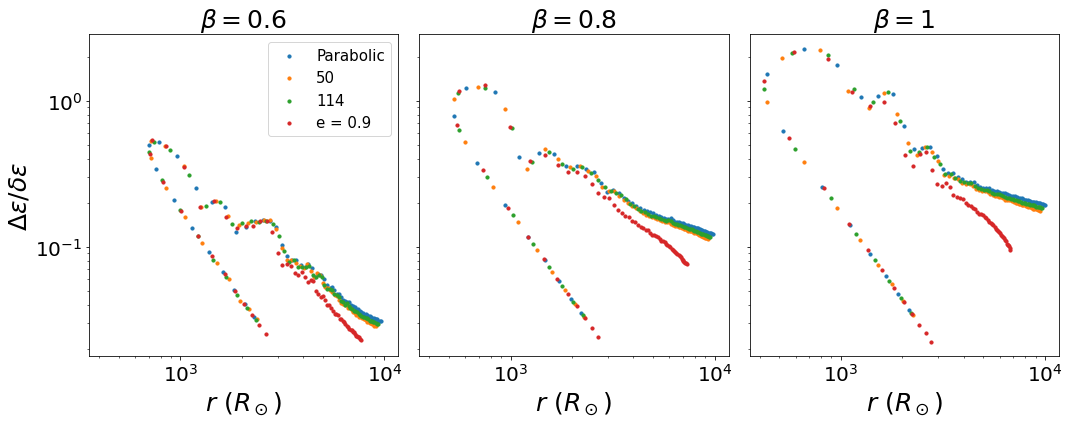

In [21]:
lens = 65
f, ax = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
'''smooth_evol(raw_0690, ax[0], 'Parabolic')
smooth_evol(raw50_0690, ax[0], '50')
smooth_evol(raw114_0690, ax[0], '114')
smooth_evol(rawe_0690, ax[0], 'low e')
smooth_evol(raw_0890, ax[1], 'Parabolic')
smooth_evol(raw50_0890, ax[1], '50')
smooth_evol(raw114_0890, ax[1], '114')
smooth_evol(raw_190, ax[2], 'Parabolic')
smooth_evol(raw50_190, ax[2], '50')
smooth_evol(raw114_190, ax[2], '114')
smooth_evol(rawe_190, ax[2], 'low e')'''
parabolic = [raw_0690, raw_0890, raw_190]
eccl = [raw50_0690, raw50_0890, raw50_190]
ecch = [raw114_0690, raw114_0890, raw114_190]
ecc = [rawe_0690, rawe_0890, rawe_190]
titles = [r'$\beta=0.6$', r'$\beta=0.8$', r'$\beta=1$']
for i in range(3):
    ax[i].scatter((parabolic[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  parabolic[i]['y'][:lens],
                  label='Parabolic',
                  s=10)
    ax[i].scatter((eccl[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  eccl[i]['y'][:lens],
                  label='50',
                  s=10)
    ax[i].scatter((ecch[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  ecch[i]['y'][:lens],
                  label='114',
                  s=10)
    ax[i].scatter((ecc[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  ecc[i]['y'][:lens],
                  label='e = 0.9',
                  s=10)
    ax[i].set_title(titles[i], fontsize=25)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].tick_params(labelsize=20)
    ax[i].set_xlabel(r'$r\ (R_\odot)$', fontsize=25)
ax[0].set_ylabel(r'$\Delta \epsilon/\delta \epsilon$', fontsize=25)
#ax[0].set_ylim(2e-2, 3)
ax[0].legend(fontsize=15)
f.tight_layout()
f.savefig('/Users/chang/Desktop/Energy_Dispersion.png')